# Penalty Comparison: fidelity vs sensitivity as a function of λ (sensitivity weight)

This notebook compares the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors. It's strucuted as follows:
* Imports
* Problem Setups: Here we compare the effect of the toggling frame robustness objective on additive and multiplicative errors without any variational states.
    * Base case: unitary smooth pulse problem w/o any robustness or sentivity objectives
    * Toggle Robustness: Optimize pulses for toggle-frame robustness
* Plot Fidelity vs. Error
* Plot Trajectories and Control pulses
* Pareto Frontiers of Fidelity vs. Robustness Penality

## Imports

In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
# Pkg.develop(path="../../Piccolissimo.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using NamedTrajectories
using TrajectoryIndexingUtils
using Random
using CSV
using Measures: mm
using Random
using FilePathsBase, FileIO

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`


## Problem Setups
Here, we first setup the quantum systems and solve for optimal pulses. There is the default smooth unitary pulse case and the toggle-fram robustness subject to three error models (additive error, mujltiplcative error, both).

#### Preliminary Variables

In [7]:
# Problem parameters
T = 20
Δt = 0.2
U_goal = GATES.X
H_drive = [PAULIS.X, PAULIS.Y]
rob_scale = 1 / 8.0
piccolo_opts = PiccoloOptions(verbose=true)
da_bound=Inf
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 2

Toggle setup

In [8]:
n_drives = sys.n_drives
n_guesses = 3
def_seeds = []
add_seeds = []
mult_seeds = []
both_seeds = []

for i in 1:n_guesses
    Random.seed!(i*124)
    a_bounds = fill(1.0, n_drives)
    da_bounds = fill((5+0.5*i)π*Δt/T, n_drives)
    dda_bounds = fill(1.0, n_drives)
    control_bounds = (a_bounds, da_bounds, dda_bounds)
    def_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    system=sys
                )
    push!(def_seeds, def_traj)

    add_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    system=sys
                )

    push!(add_seeds, add_traj)

    mult_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                system=sys
            )

    push!(mult_seeds, mult_traj)

    both_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                system=sys
            )

    push!(both_seeds, both_traj)
end

Run all seeds for various weights (lambdas) using the toggle objective on only the additive error problem

setup the same problems for the default, multiplcative, both error cases

In [9]:
sweep_rob_loss_λ = exp.(range(log(.1), log(1), length=6))
n_seeds = n_guesses
n_lambdas = length(sweep_rob_loss_λ)

default_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
add_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
mult_probs = Matrix{Any}(undef, n_seeds, n_lambdas)

Hₑ_add = a -> PAULIS.X
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive


for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ) 

        # Add problem
        add_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(add_seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=λ
        )
        solve!(add_prob; max_iter=50, print_level=5)
        add_probs[i, λ_idx] = add_prob

        # default
        defaults = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(def_seeds[i]))
        solve!(defaults; max_iter=50, print_level=5)
        default_probs[i,λ_idx] = defaults

        # mult
        mult_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(mult_seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_mult,
            Q_t=λ
        )
        solve!(mult_prob; max_iter=50, print_level=5)
        mult_probs[i, λ_idx] = mult_prob
    end
end


    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:     2082
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    24193

Total number of variables............................:      288
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      136
                     va

In [5]:
# both
# both_probs = Matrix{Any}(undef, n_seeds, n_lambdas)

# # Optimization loop with index counter

#         # Both problem
#         both_prob = UnitaryVariationalProblem(
#             varsys_both, U_goal, T, Δt;
#             init_trajectory=deepcopy(varsys_both_seeds[i]),
#             variational_scales=[rob_scale,rob_scale],
#             sensitive_times=[[T]],
#             piccolo_options=piccolo_opts,
#             Q_s=λ
#         )
#         solve!(both_prob; max_iter=200, print_level=5)
#         both_probs[i, λ_idx] = both_prob
#     end
# end

plot fid v err magnitude for the above problems

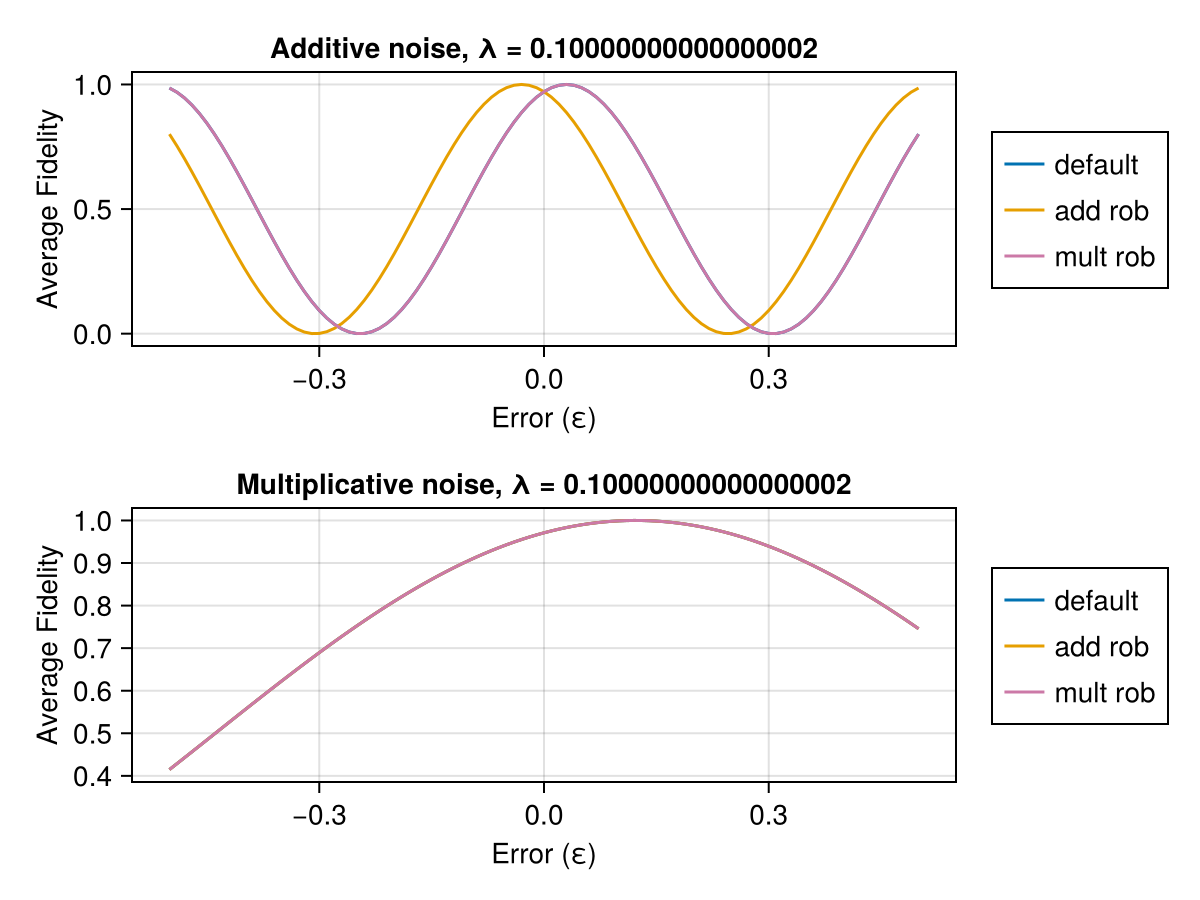


Processing λ = 0.10000000000000002

Processing λ = 0.15848931924611137

Processing λ = 0.25118864315095807

Processing λ = 0.39810717055349726

Processing λ = 0.6309573444801932

Processing λ = 1.0

Processing λ = 0.10000000000000002

Processing λ = 0.15848931924611137

Processing λ = 0.25118864315095807

Processing λ = 0.39810717055349726

Processing λ = 0.6309573444801932

Processing λ = 1.0

Processing λ = 0.10000000000000002

Processing λ = 0.15848931924611137

Processing λ = 0.25118864315095807

Processing λ = 0.39810717055349726

Processing λ = 0.6309573444801932

Processing λ = 1.0


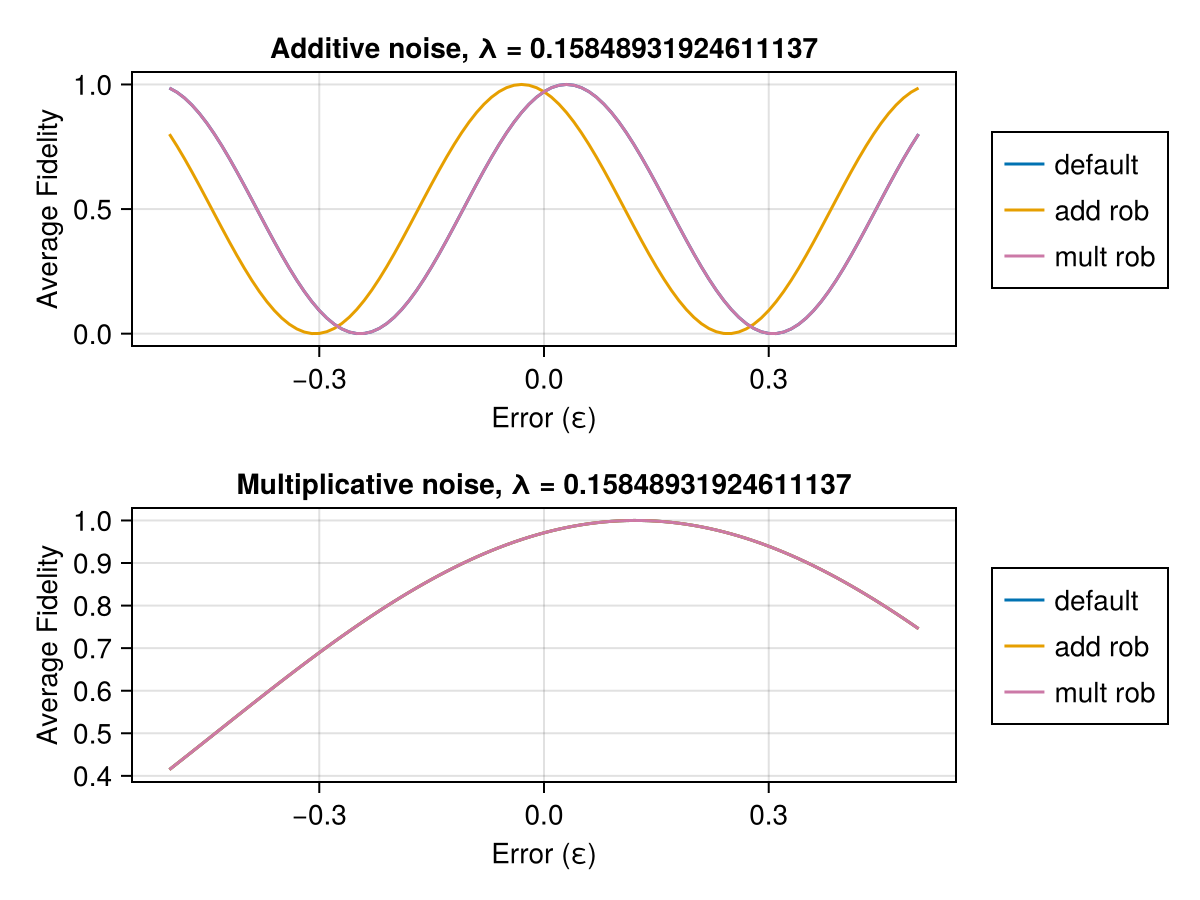

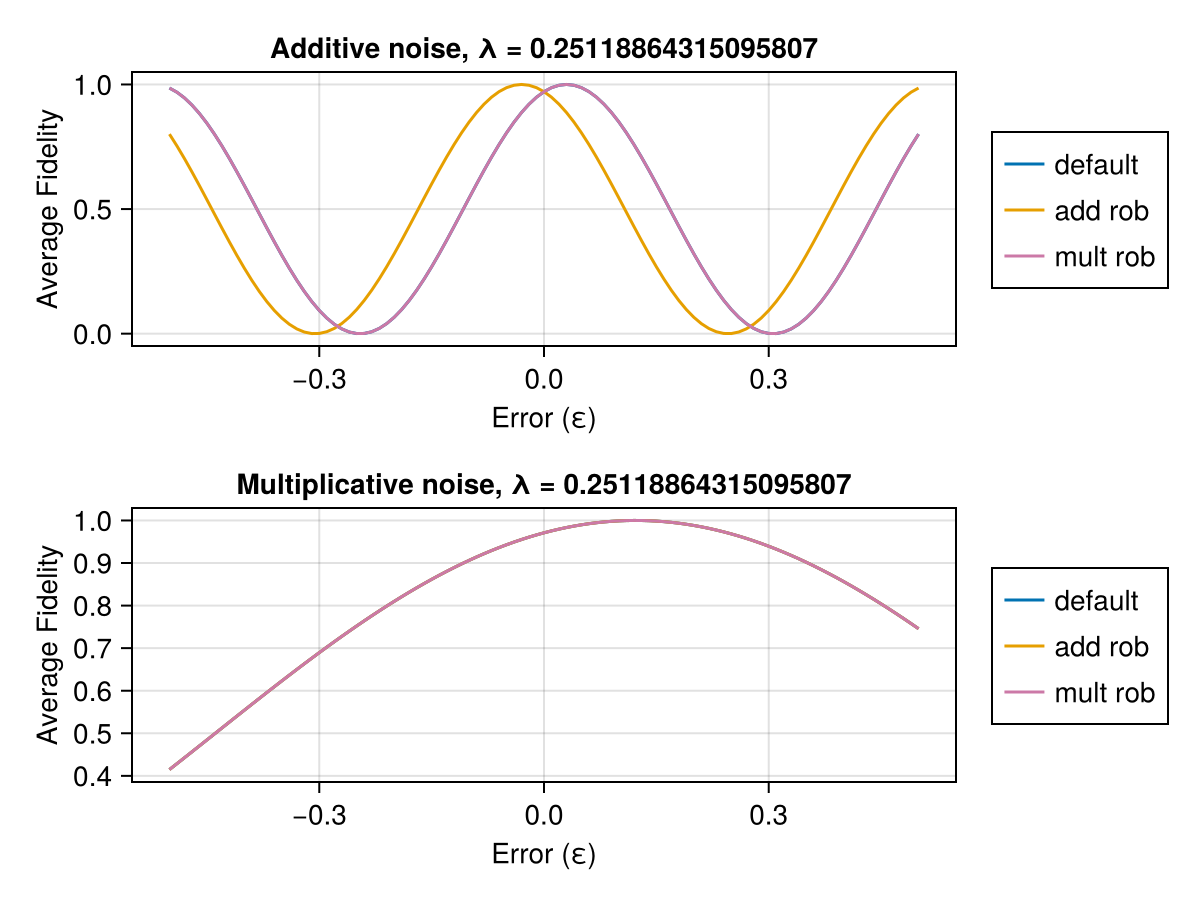

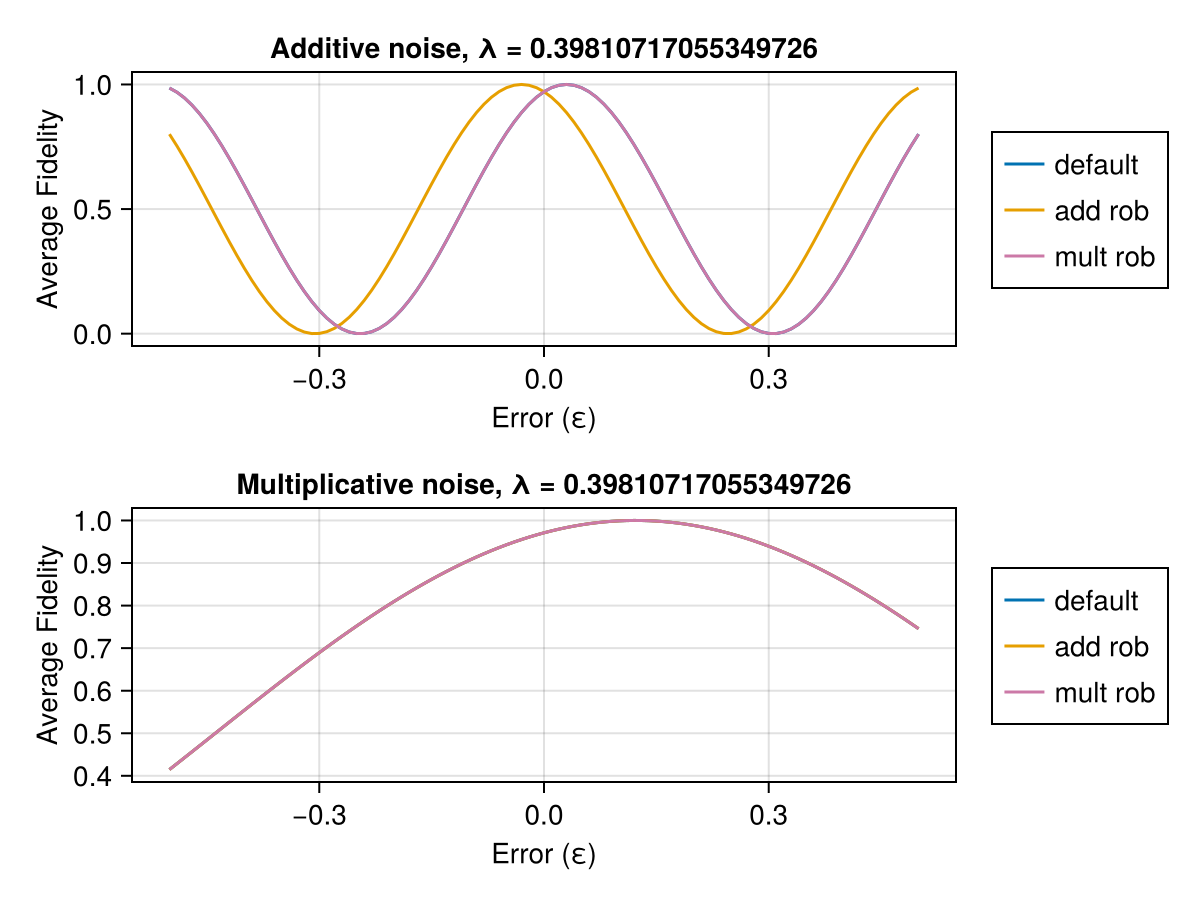

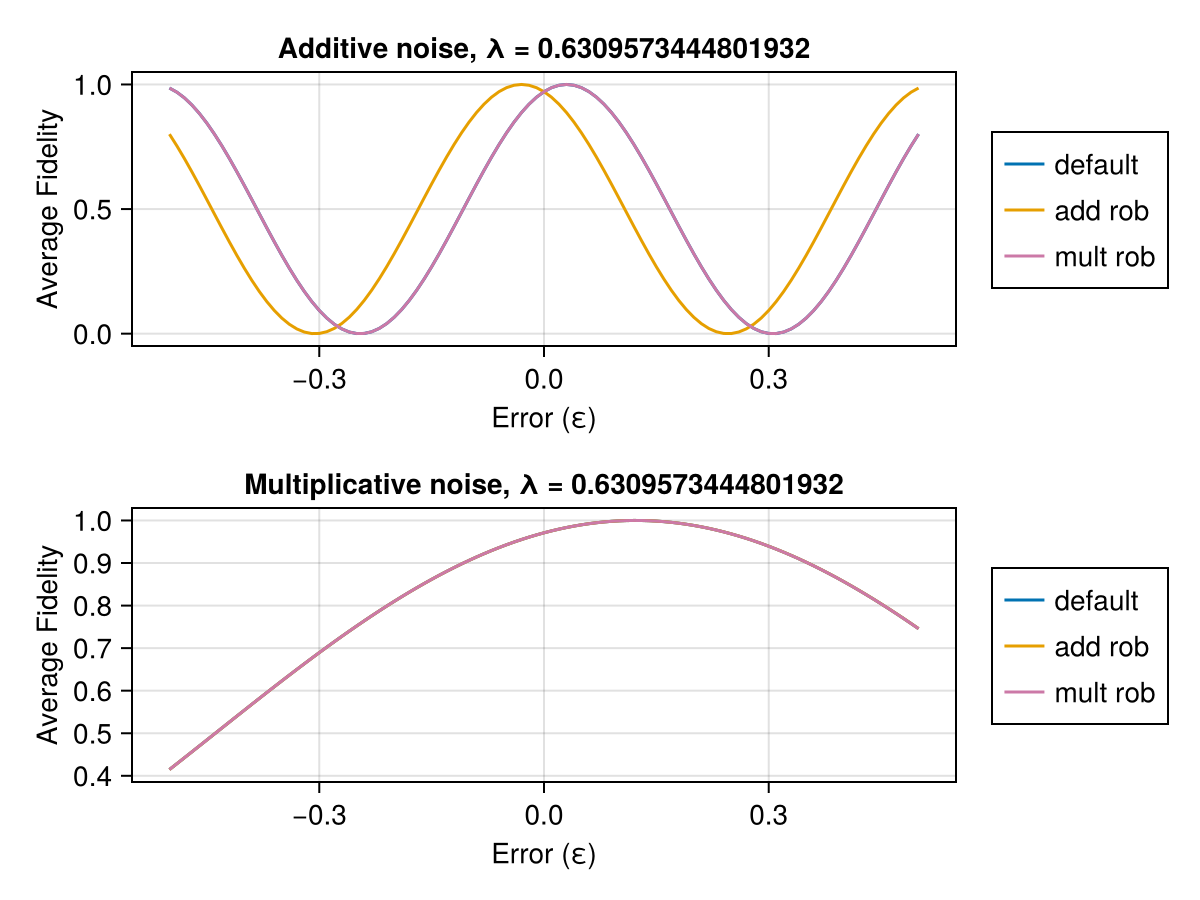

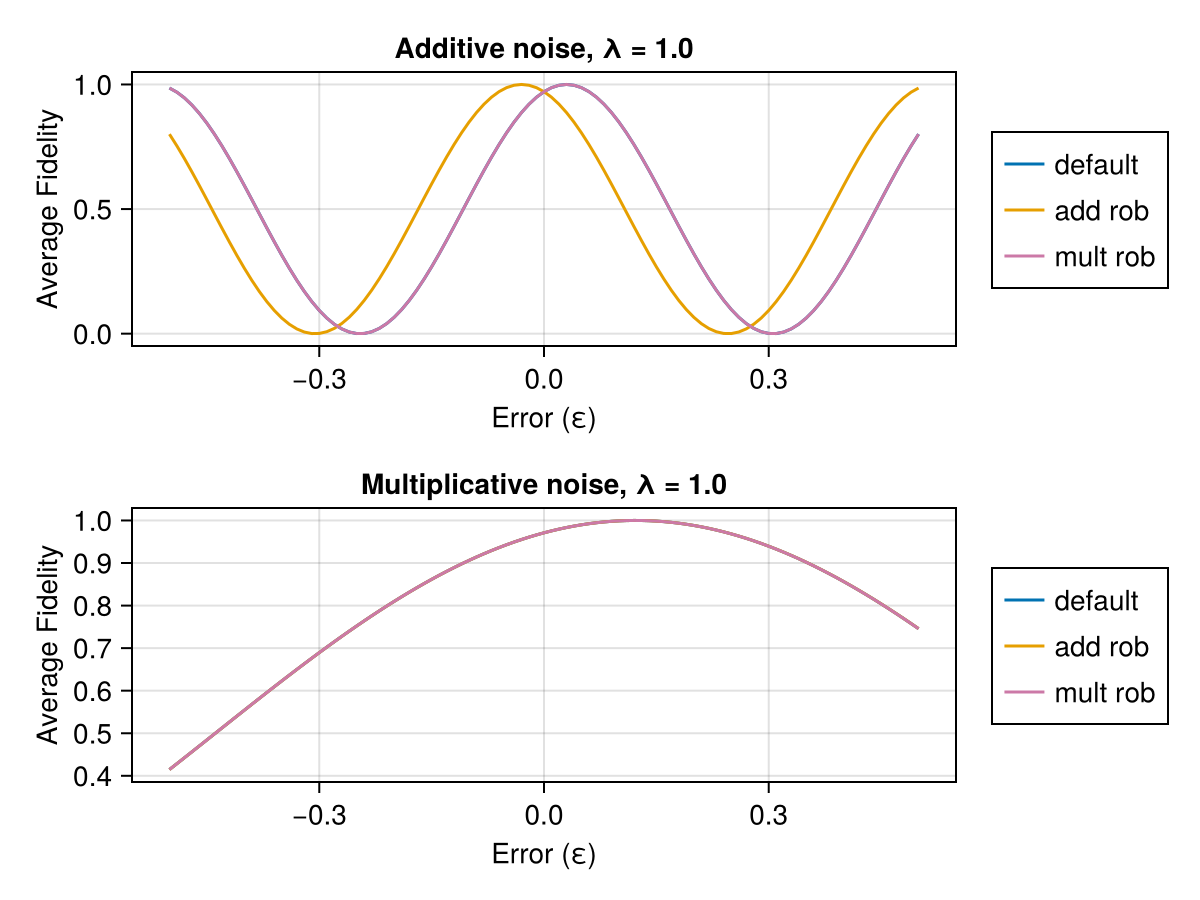

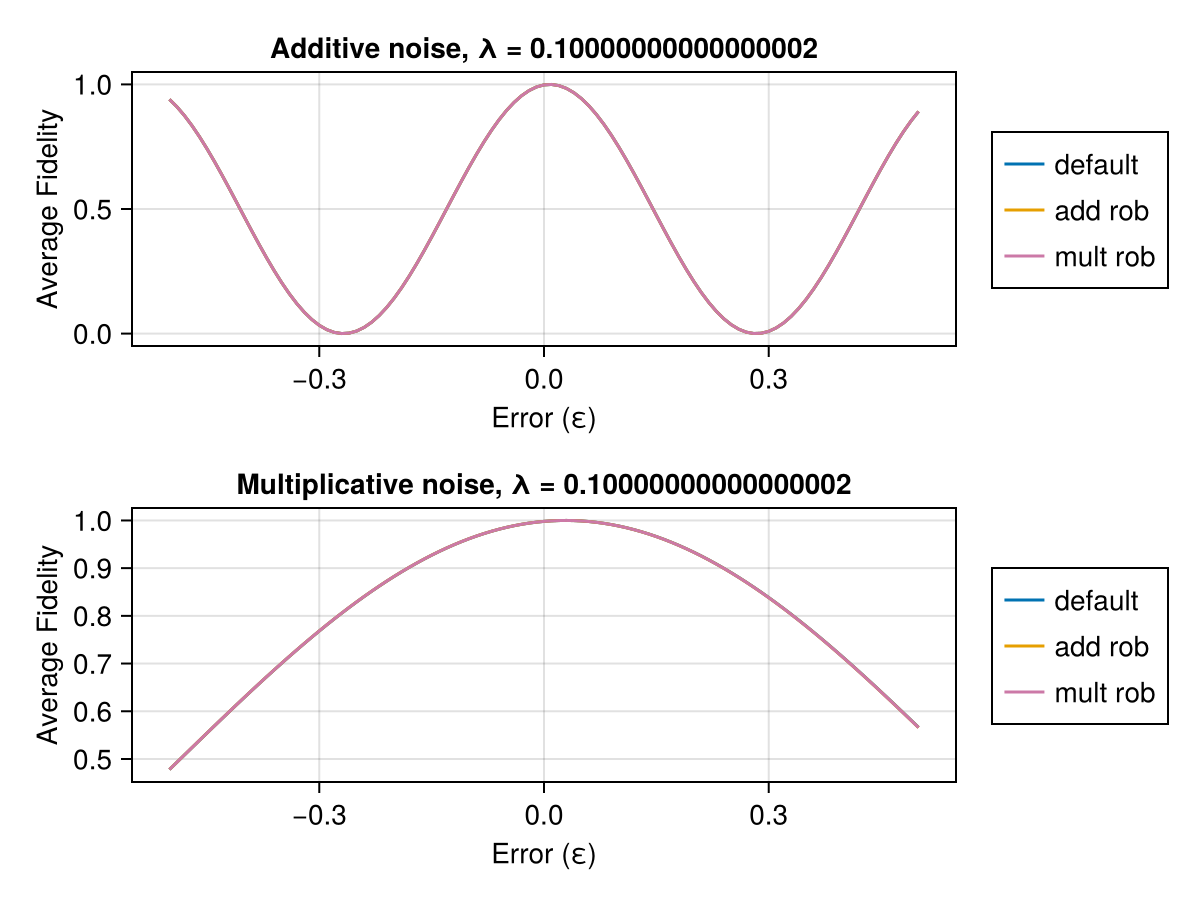

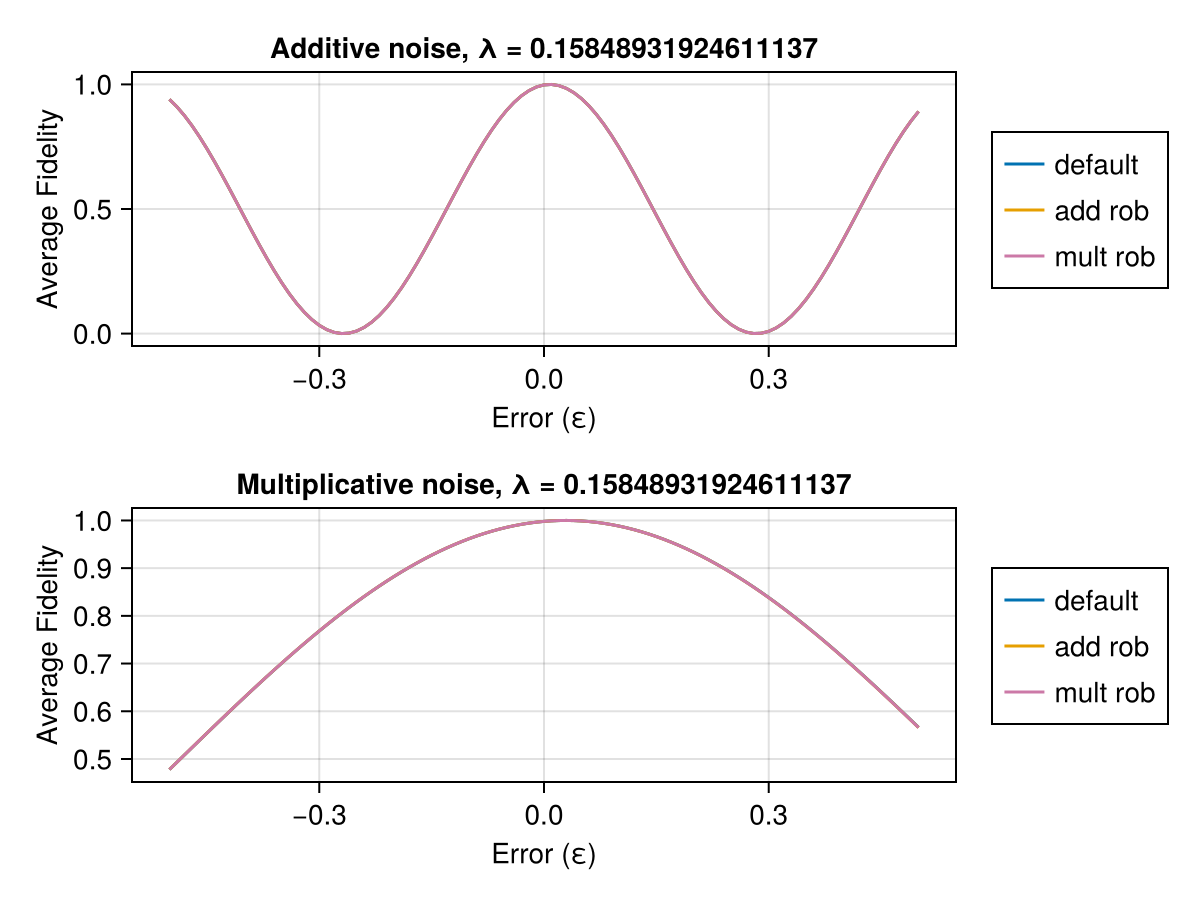

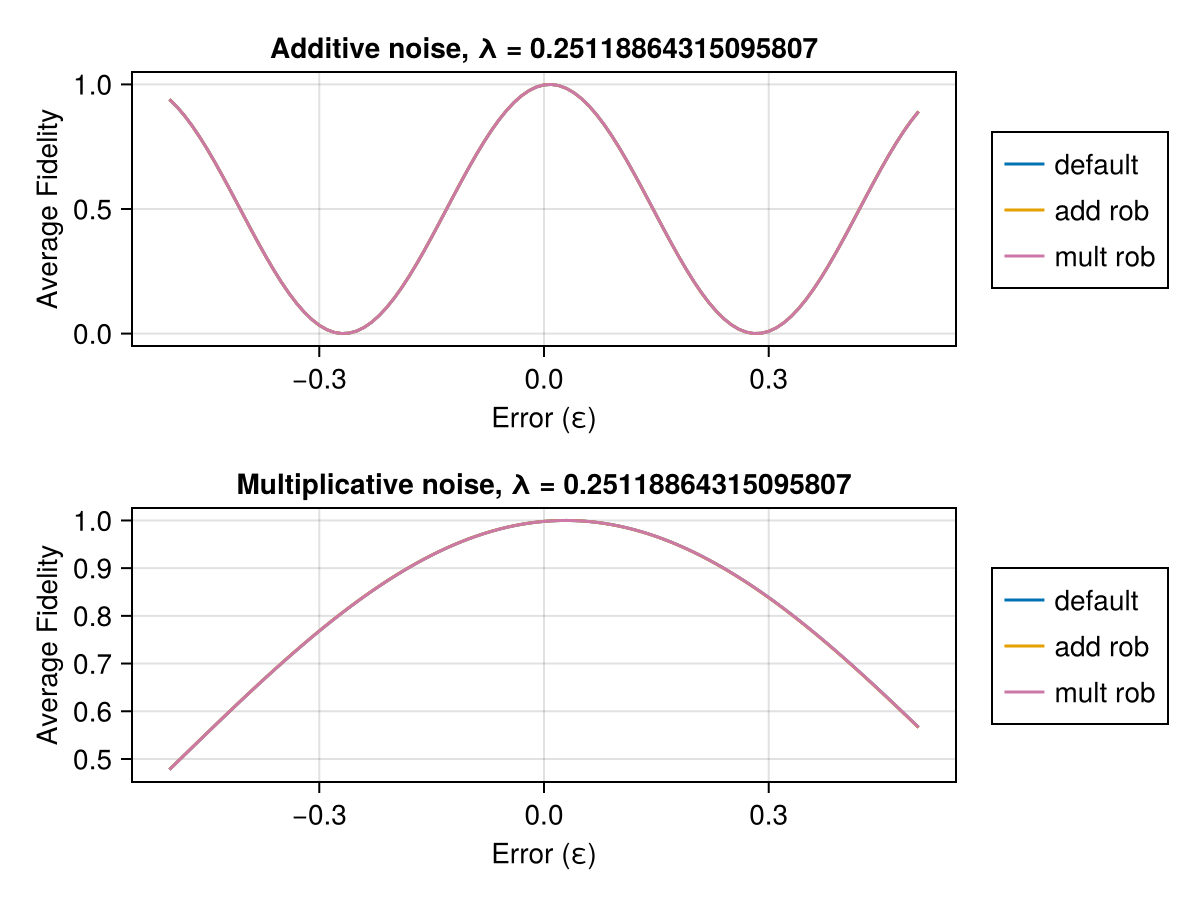

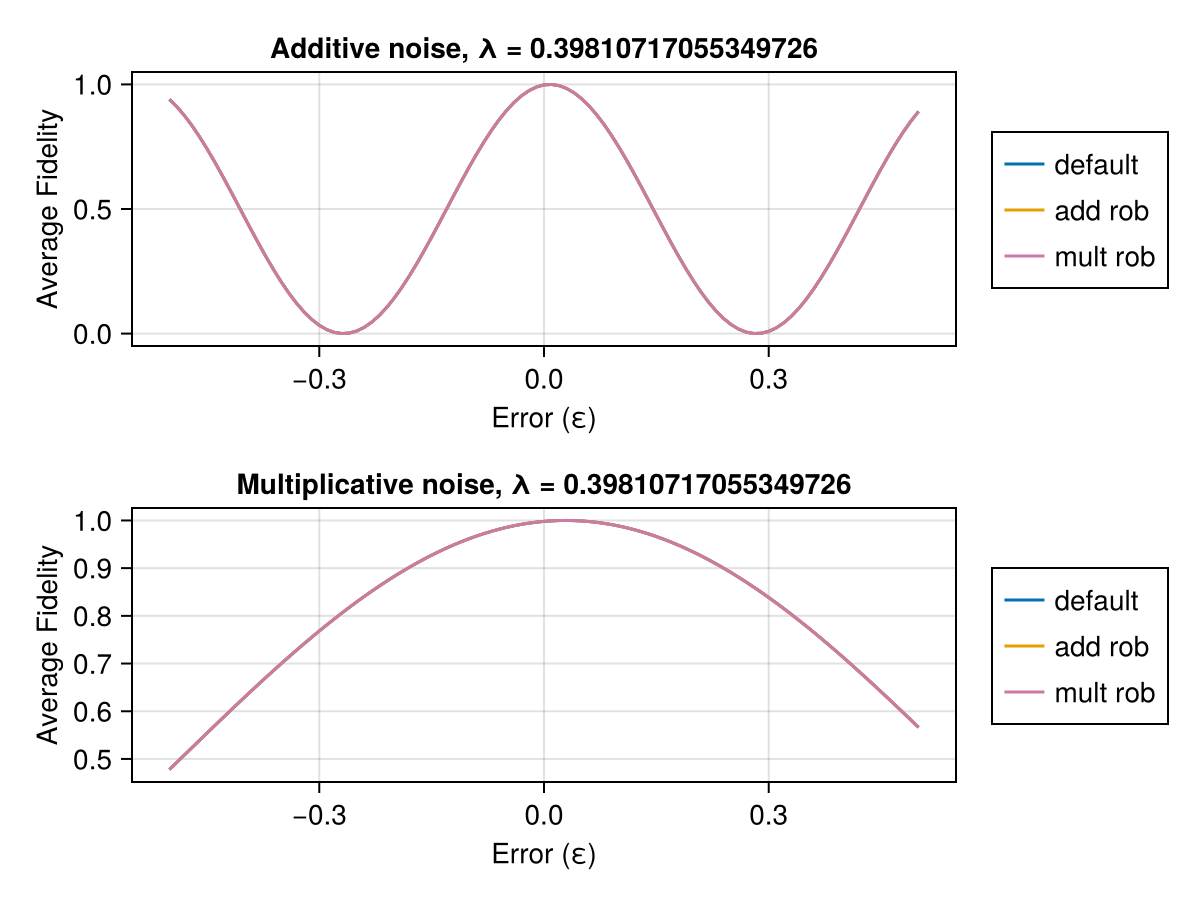

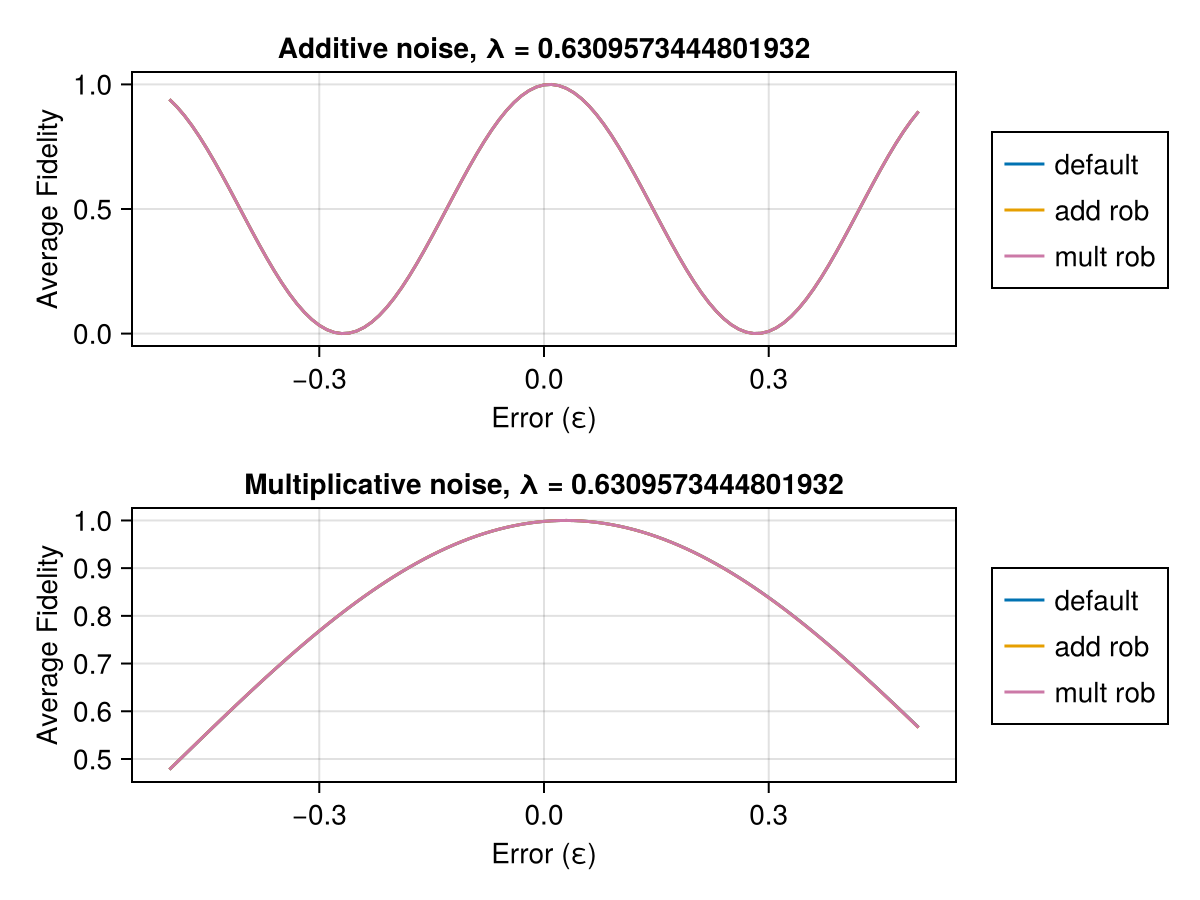

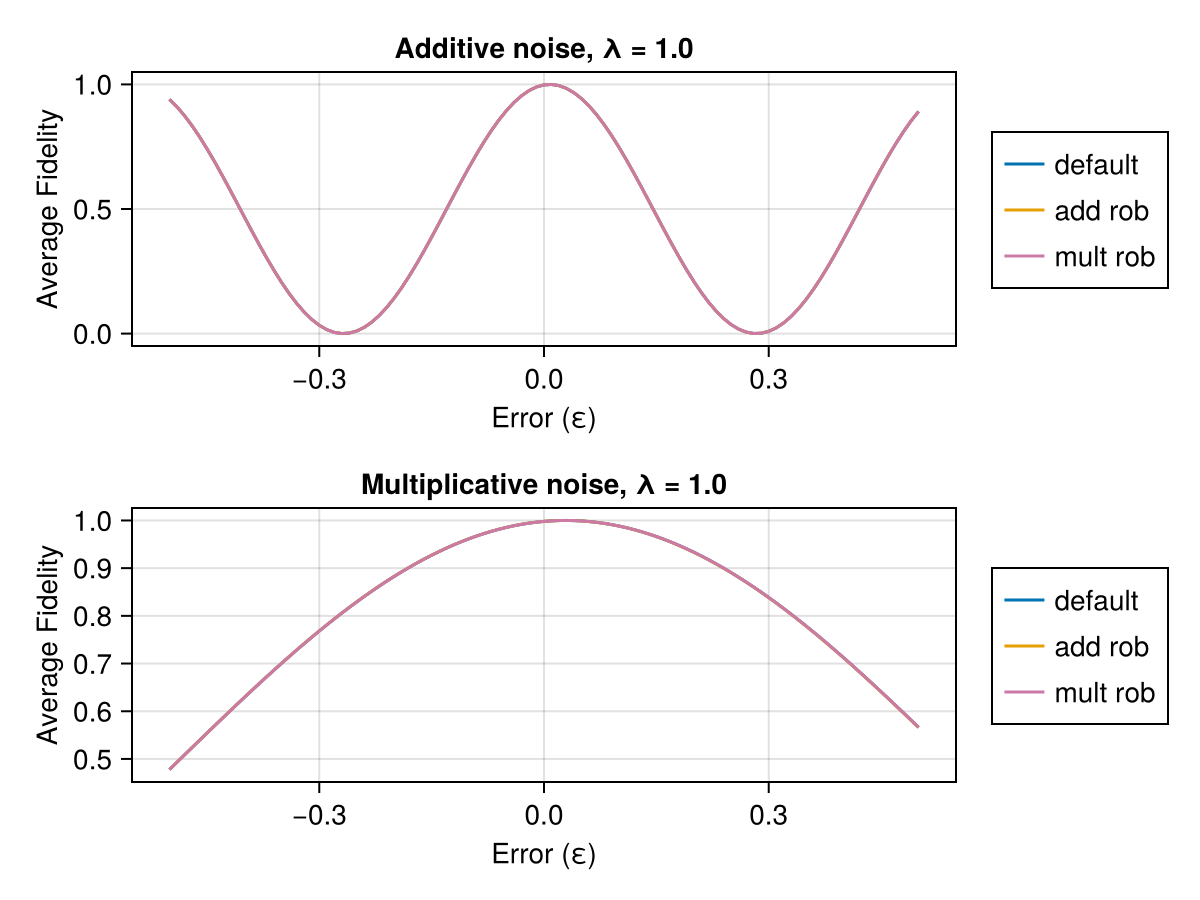

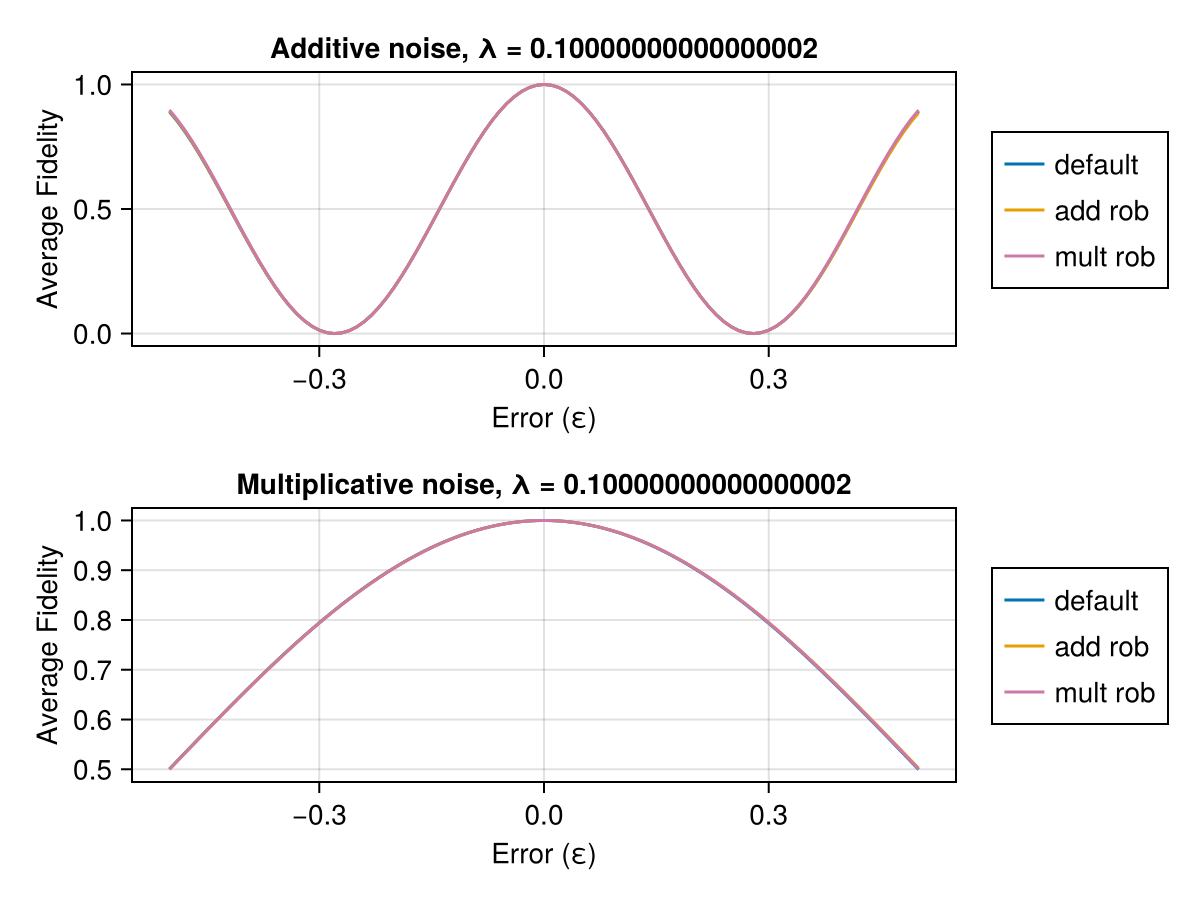

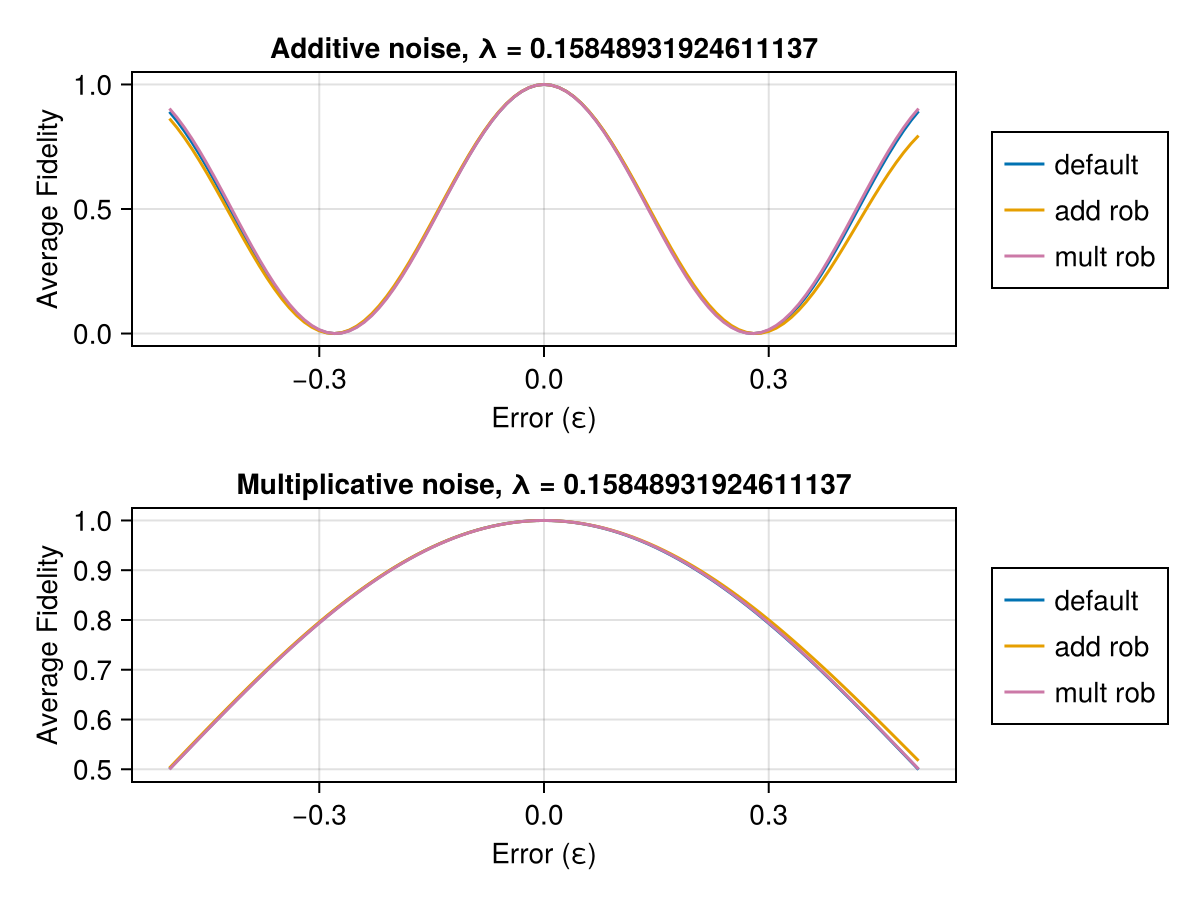

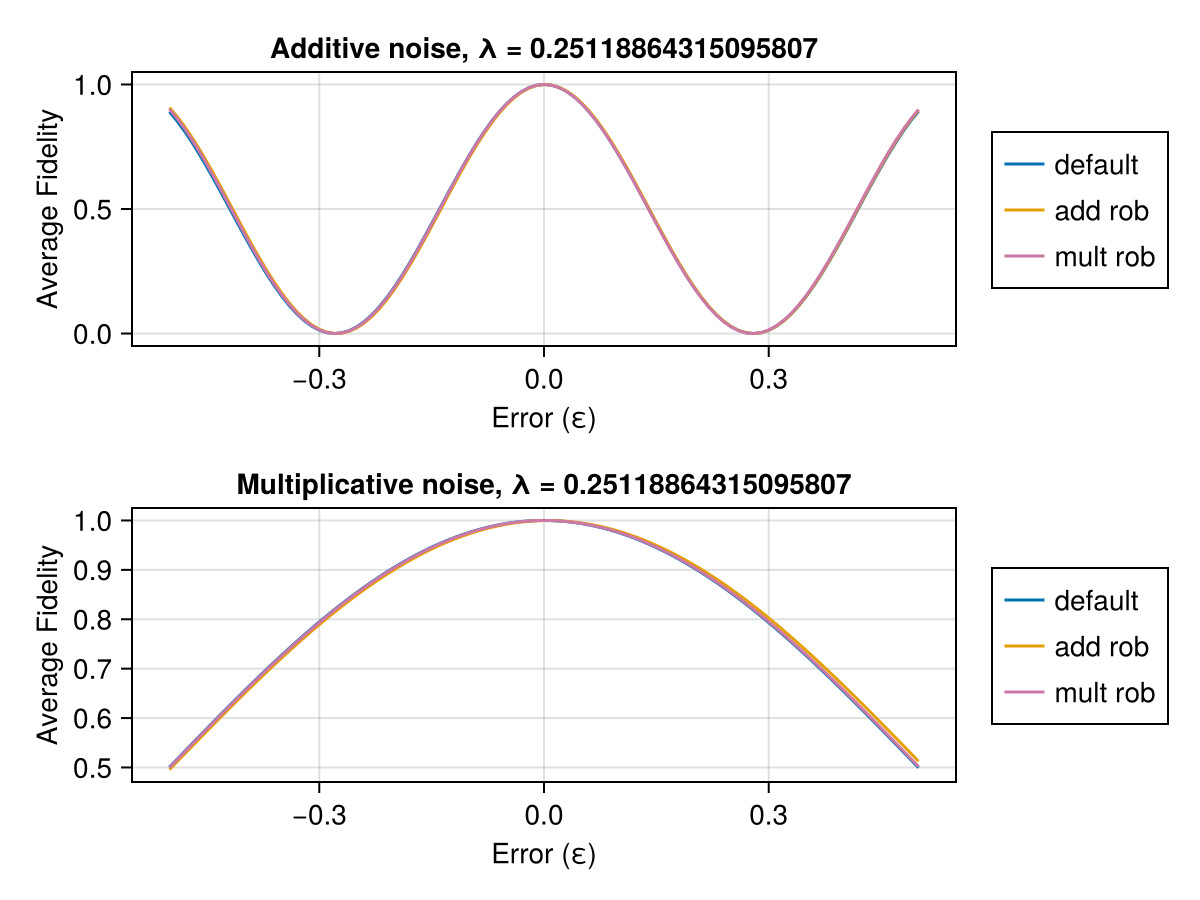

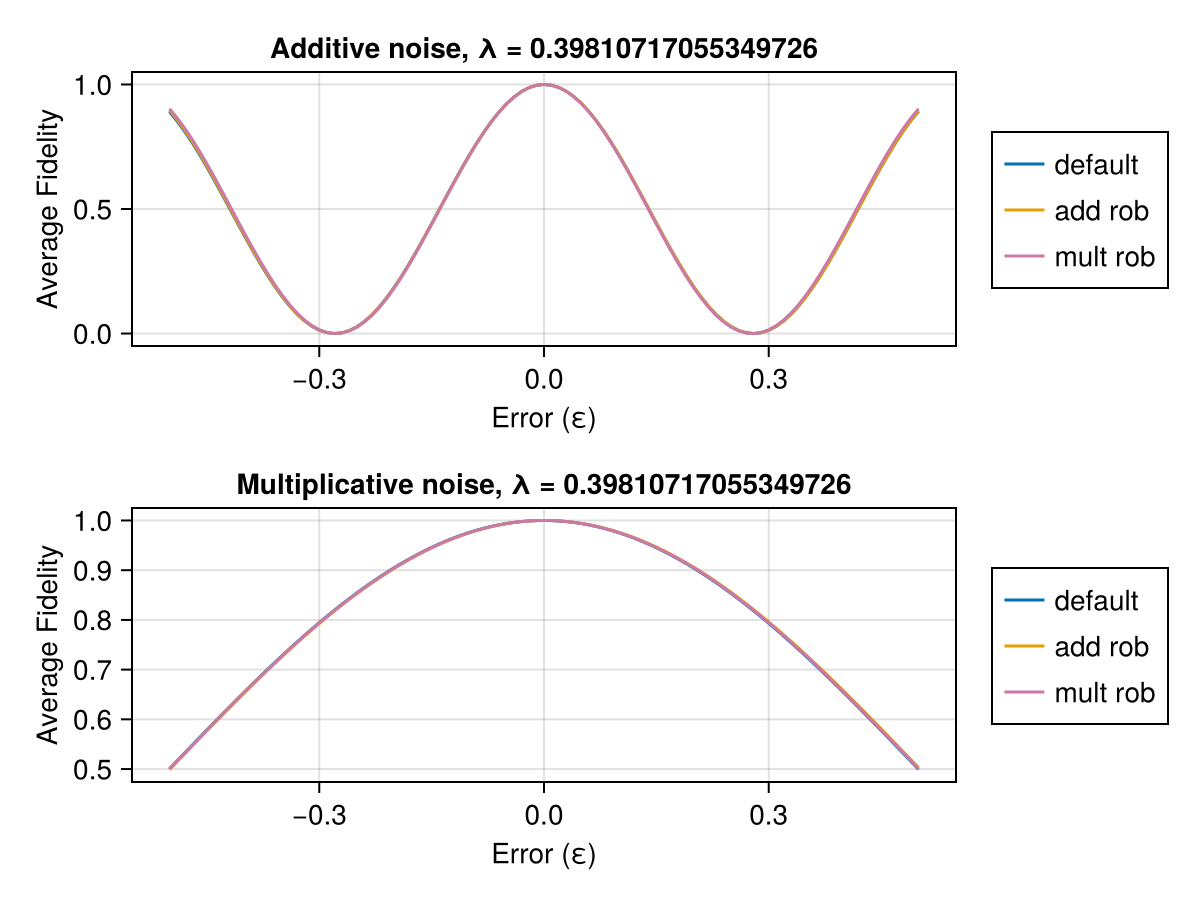

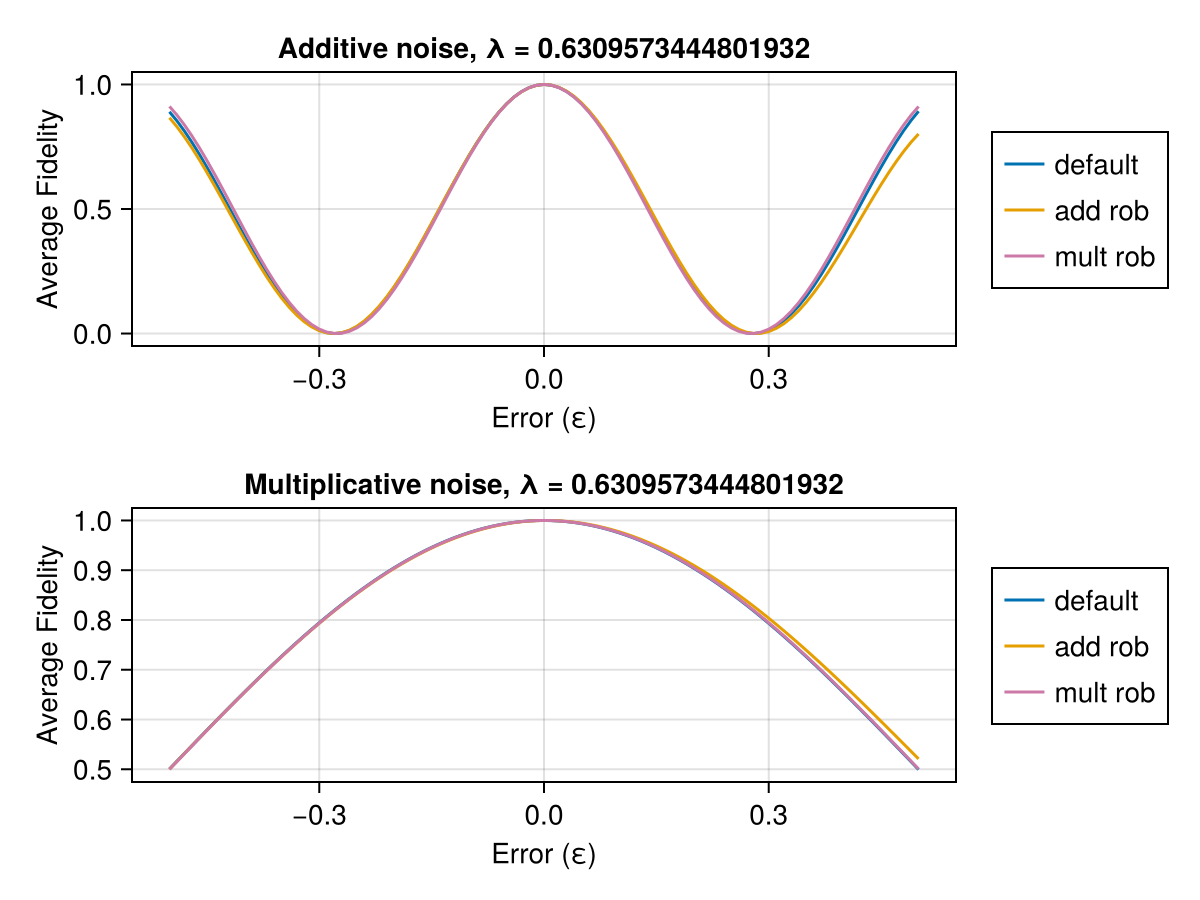

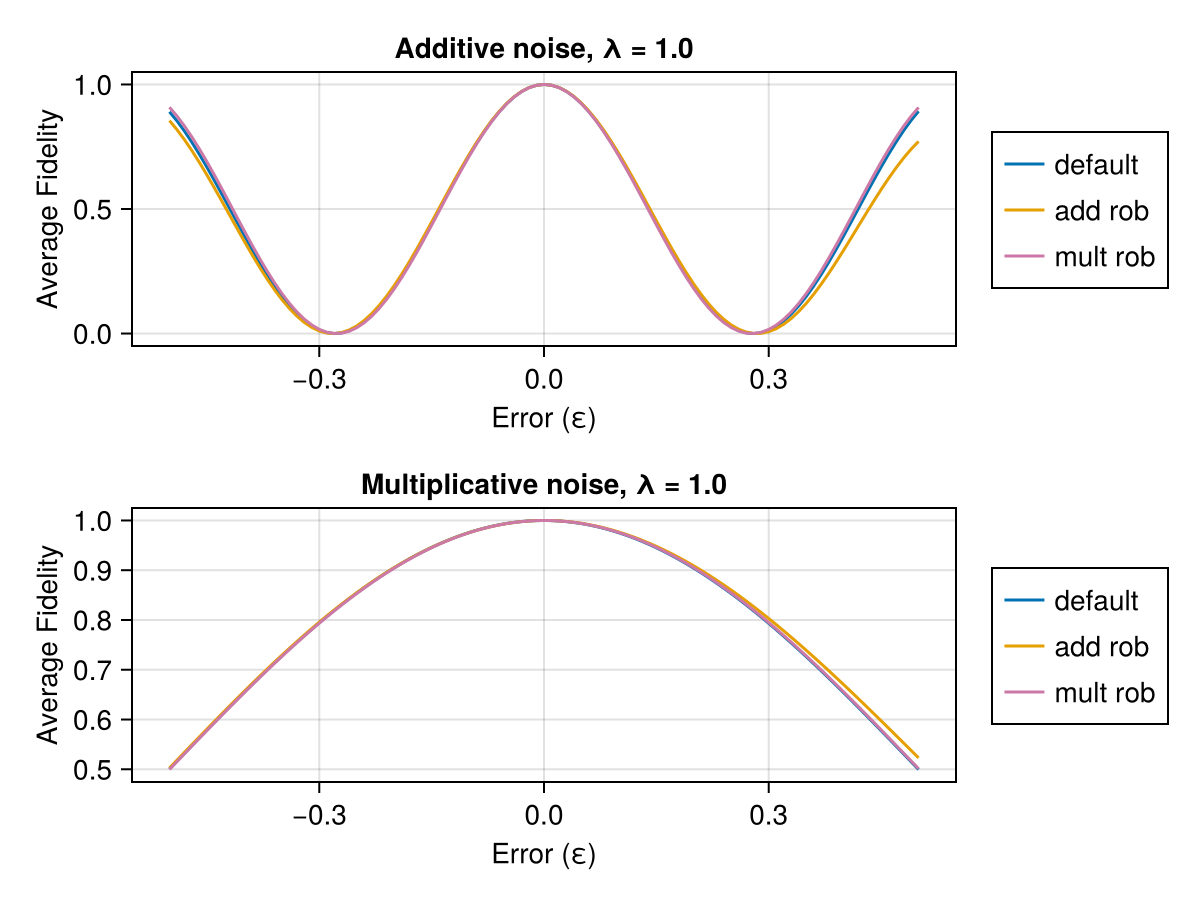

In [6]:
H_drive_add = H_drive
εs = -0.5:0.01:0.5
colors = Makie.wong_colors()

# Plot for each λ
for seed_idx in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        println("\nProcessing λ = $λ")
        f = Figure()
        ax1 = Axis(f[1, 1], title="Additive noise, λ = $λ", xlabel="Error (ε)", ylabel="Average Fidelity")
        ax2 = Axis(f[2, 1], title="Multiplicative noise, λ = $λ", xlabel="Error (ε)", ylabel="Average Fidelity")
        # ax3 = Axis(f[3, 1], title="Both noises, λ = $λ", xlabel="Error (ε)", ylabel="Average Fidelity")

        # Define system functions for additive and multiplicative noise
        additive_system = ε -> QuantumSystem(ε * PAULIS.X, H_drive)
        multiplicative_system = ε -> QuantumSystem((1 + ε) * H_drive)
        # both_system = ε -> QuantumSystem(ε * PAULIS.X, [(1 + ε) * H_drive])
        # Plot data structure: (matrix, label, color)
        plot_configs = [
            (default_probs, "default", colors[1]),
            (add_probs, "add rob", colors[2]),
            (mult_probs, "mult rob", colors[4])#,
            # (both_adj_probs, "both rob", colors[4])
        ]

        # Plot for both noise types
        for (probs_matrix, label, color) in plot_configs
            # Additive noise
            prob = probs_matrix[seed_idx, λ_idx]
            ys_add = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem(ε * PAULIS.X, H_drive)) for ε in εs]
            lines!(ax1, εs, ys_add, label=label, color=color, linestyle=:solid)

            # Multiplicative noise
            ys_mult = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem((1 + ε) * H_drive)) for ε in εs]
            lines!(ax2, εs, ys_mult, label=label, color=color, linestyle=:solid)

            # # Both noises
            # ys_both = [unitary_rollout_fidelity(prob.trajectory, QuantumSystem(ε * PAULIS.X, (1 + ε) * H_drive)) for ε in εs]
            # lines!(ax3, εs, ys_both, label=label, color=color, linestyle=:solid)
        end

        Legend(f[1, 2], ax1, position=:lb)
        Legend(f[2, 2], ax2, position=:lb)
        # Legend(f[3, 2], ax3, position=:lb)

        display(f)
    end
end

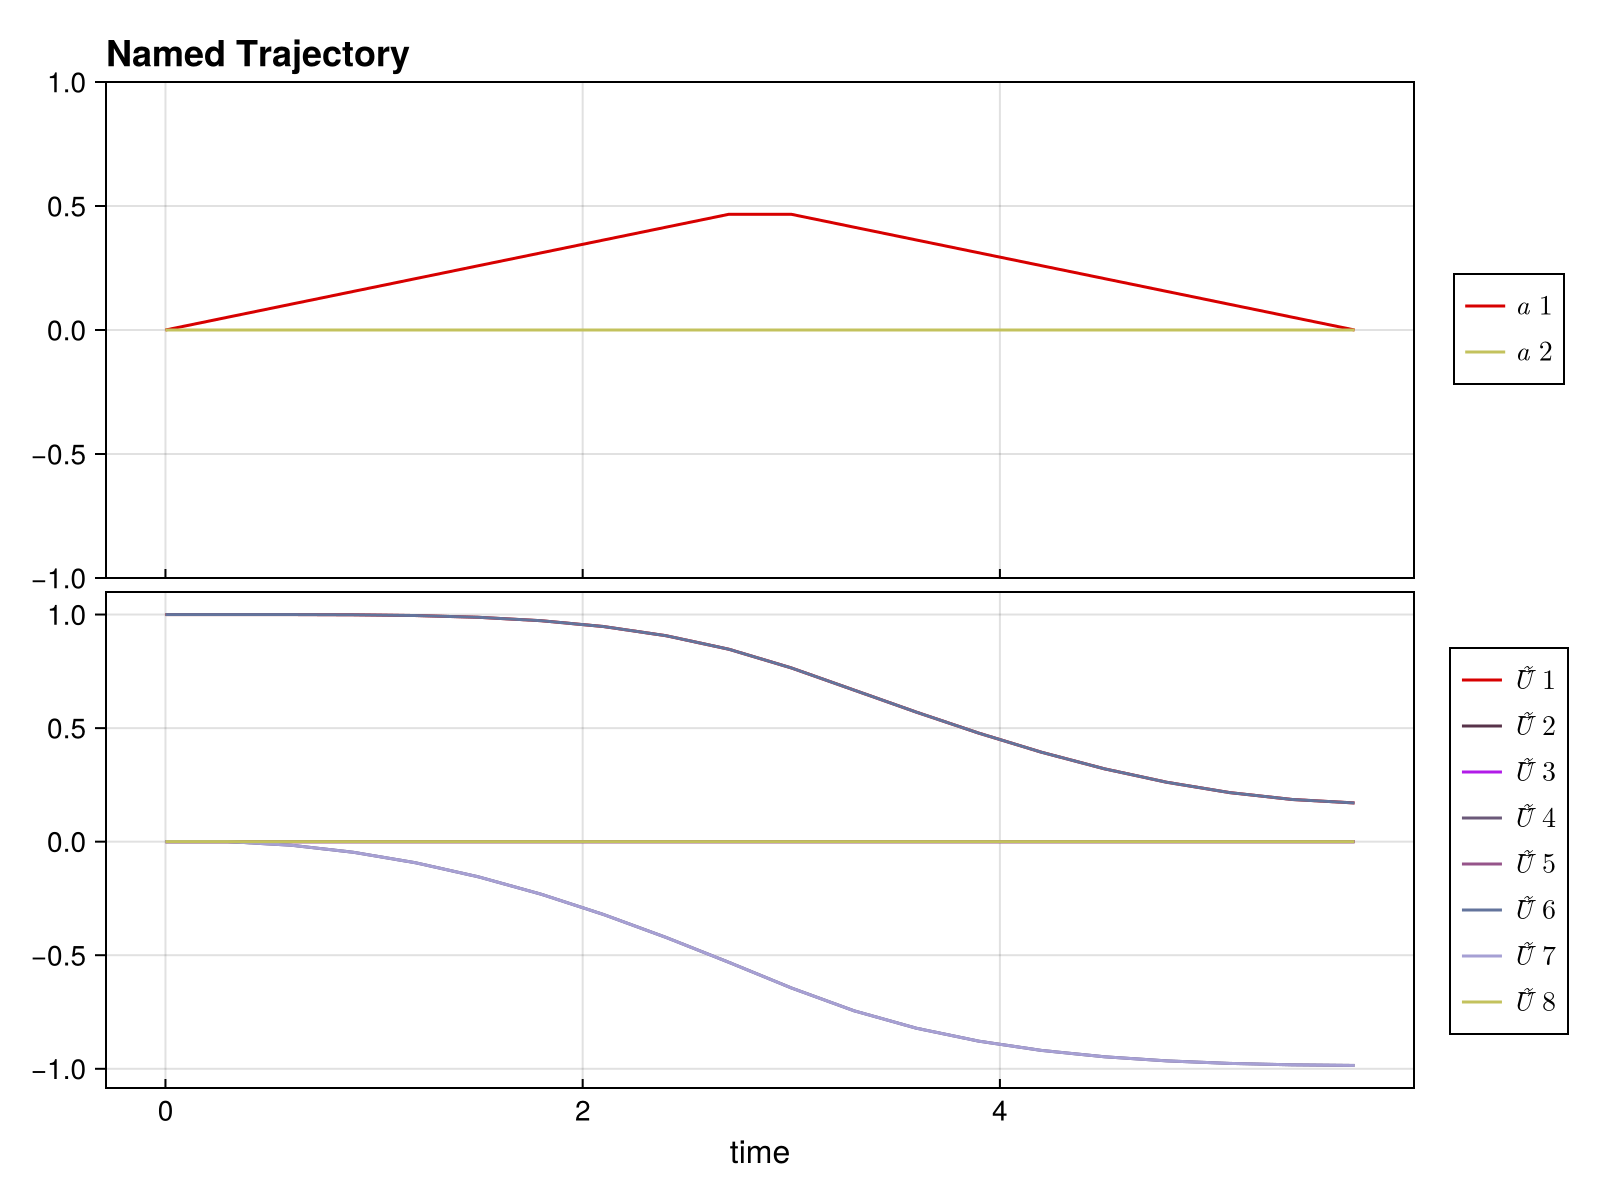

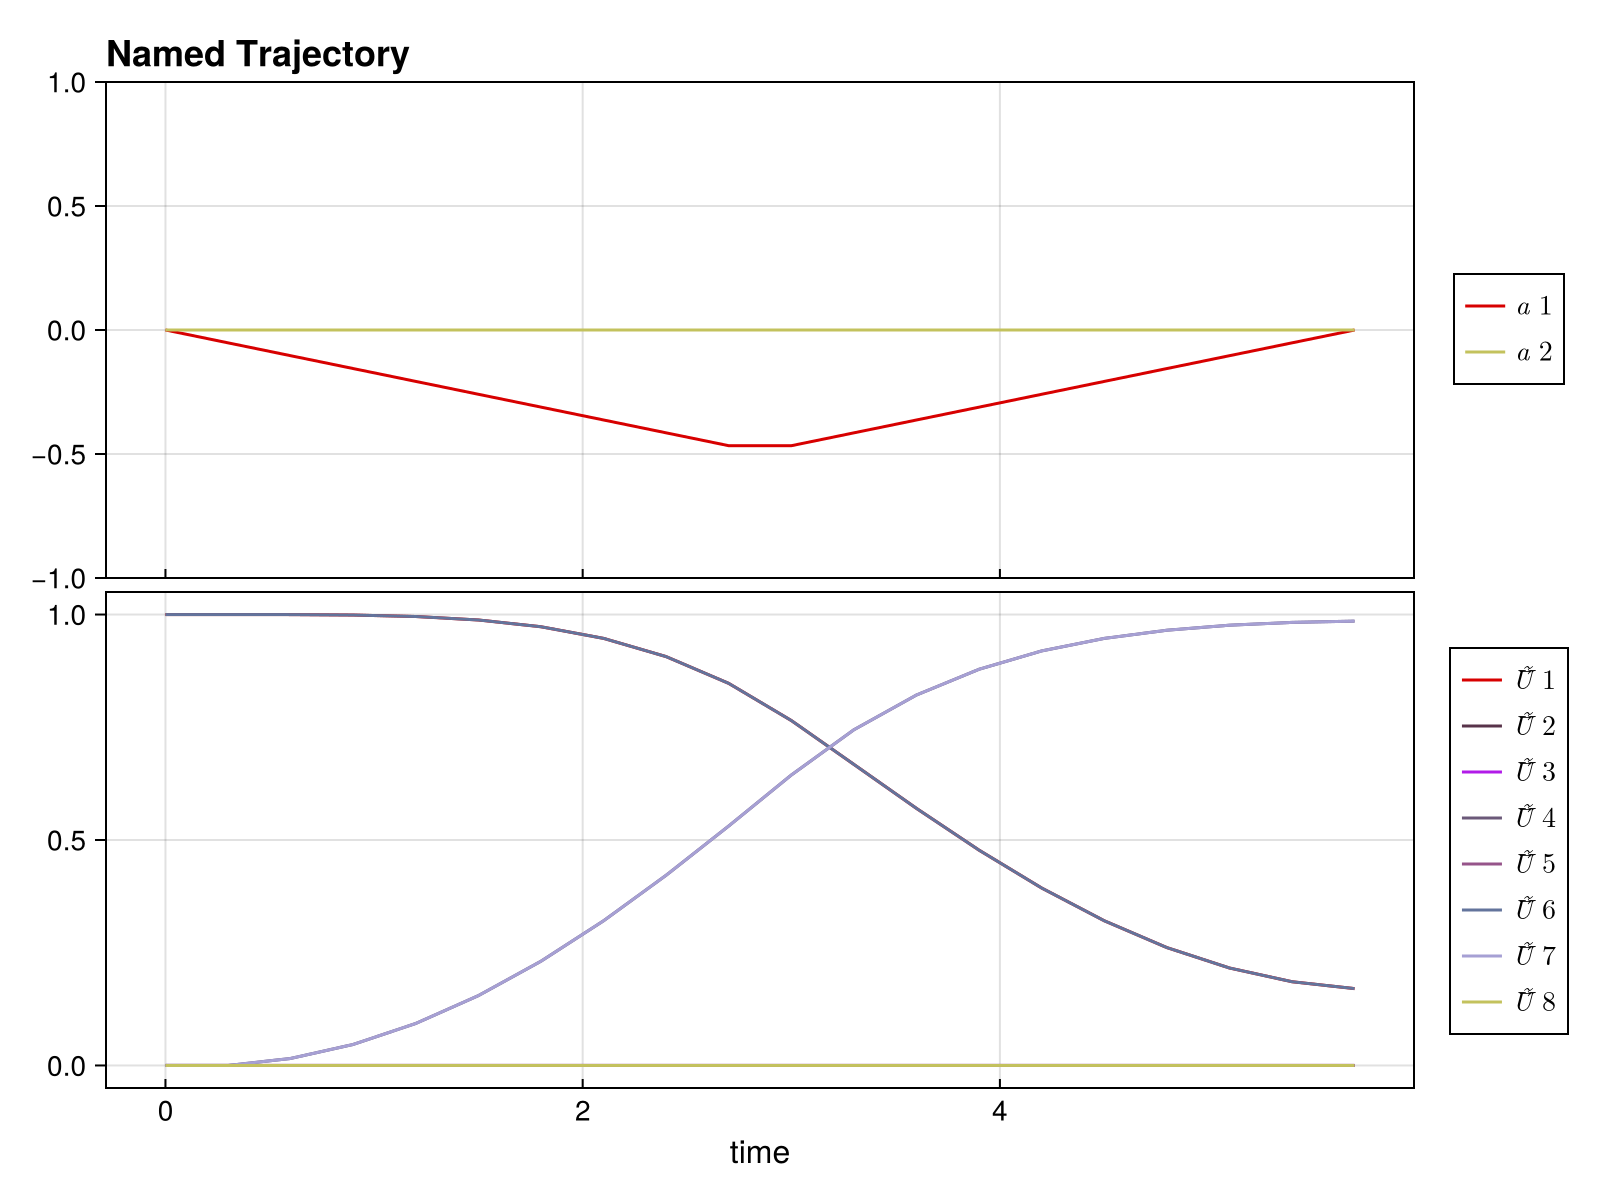

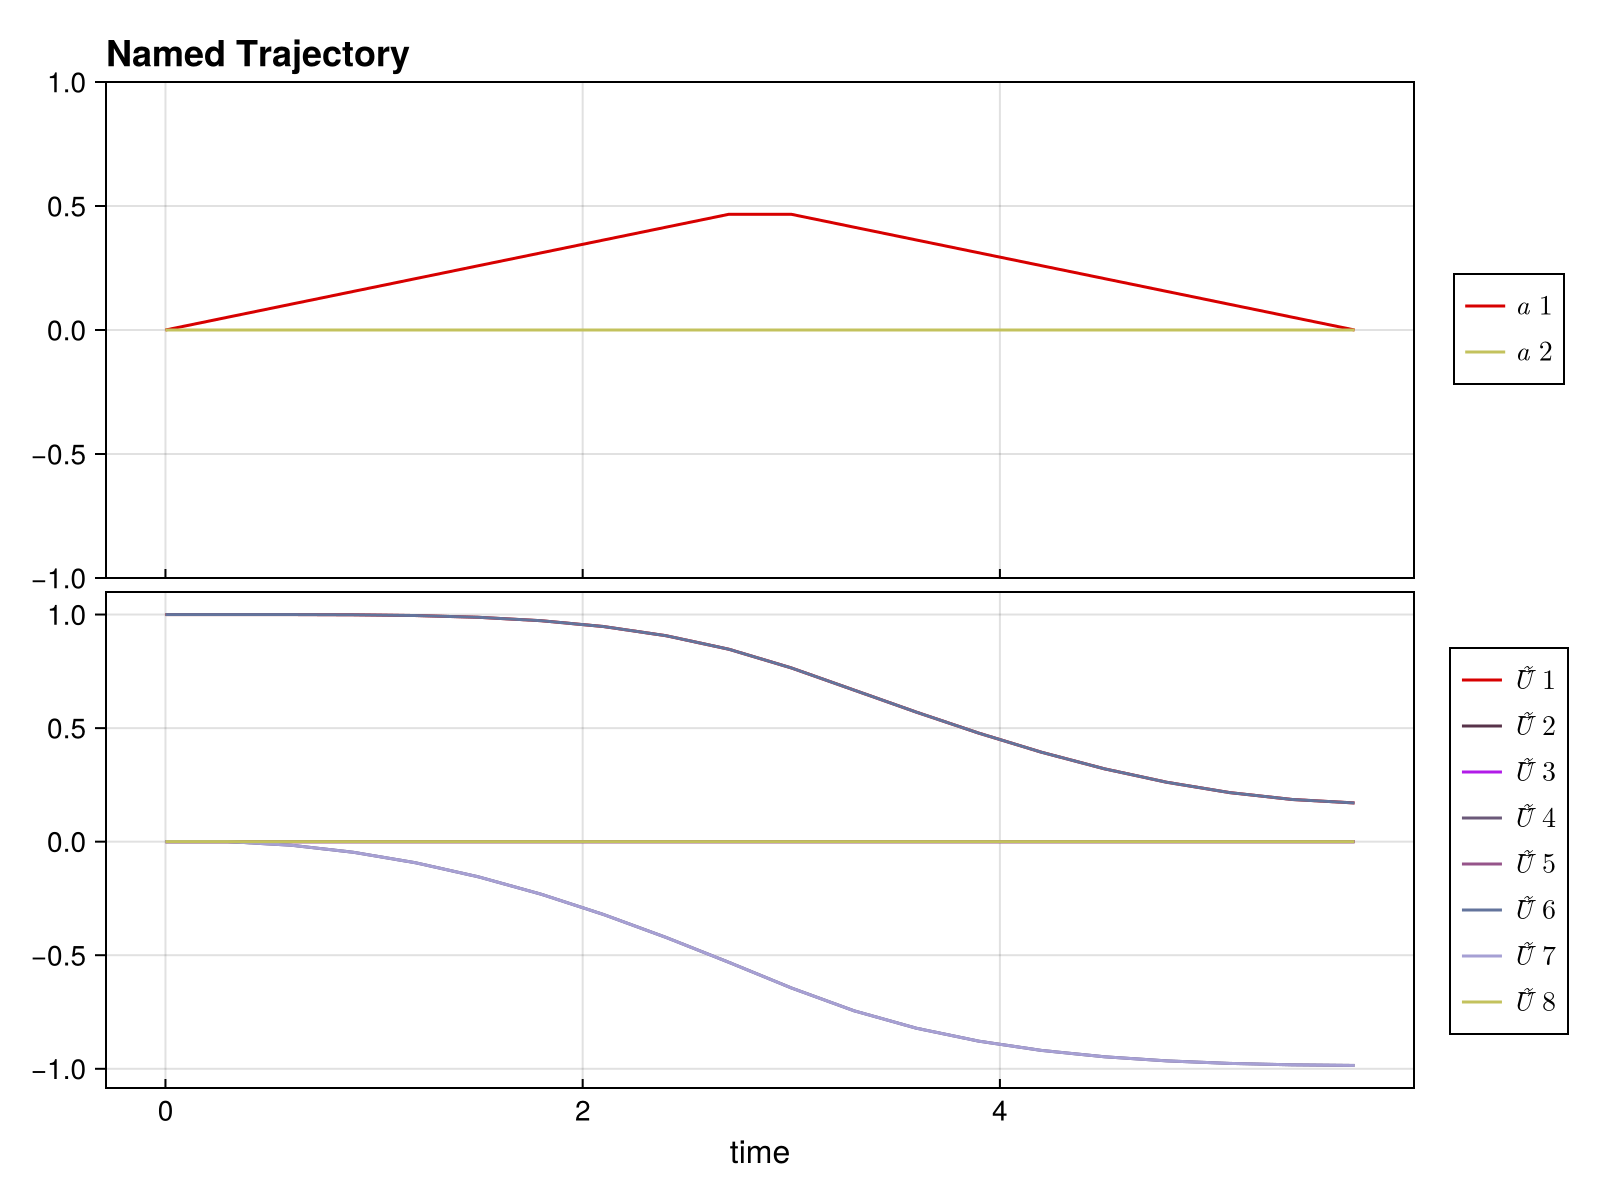

CairoMakie.Screen{IMAGE}


In [24]:
def = default_probs[1,1]
add_prob = add_probs[1,3]
mult_prob = mult_probs[1,2]
p1 = CairoMakie.plot(def.trajectory, [:a, :Ũ⃗])
p2 = CairoMakie.plot(add_prob.trajectory, [:a, :Ũ⃗])
p3 = CairoMakie.plot(mult_prob.trajectory, [:a, :Ũ⃗])
# p4 = CairoMakie.plot(both_prob.trajectory, [:a, :Ũ⃗])

display(p1)
display(p2)
display(p3)
# display(p4)

In [8]:
# Detailed results table
display("\n=== Detailed Results Table ===")
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity |")
    display("-" ^ 40)
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        def_fid = unitary_rollout_fidelity(default_probs[seed_idx, λ_idx].trajectory, sys)
        add_fid = unitary_rollout_fidelity(add_probs[seed_idx, λ_idx].trajectory, sys)
        mult_fid = unitary_rollout_fidelity(mult_probs[seed_idx, λ_idx].trajectory, sys)
        # both_fid = unitary_rollout_fidelity(both_tog_probs[seed_idx, λ_idx].trajectory, varsys_both)
        display("$(lpad(round(λ, digits=4), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) |")# $(lpad(round(both_fid, digits=6), 12)) |")
    end
end

"\n=== Detailed Results Table ==="

"\nseed idx = 1:"

"Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity |"

"----------------------------------------"

"    0.1 |      0.97097 |      0.97097 |       0.97097 |"

" 0.1585 |      0.97097 |      0.97097 |       0.97097 |"

" 0.2512 |      0.97097 |      0.97097 |       0.97097 |"

" 0.3981 |      0.97097 |      0.97094 |       0.97097 |"

"  0.631 |      0.97097 |     0.970932 |       0.97097 |"

"    1.0 |      0.97097 |     0.970932 |       0.97097 |"

"\nseed idx = 2:"

"Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity |"

"----------------------------------------"

"    0.1 |     0.998037 |     0.998067 |      0.998067 |"

" 0.1585 |     0.998037 |     0.998067 |      0.998067 |"

" 0.2512 |     0.998037 |     0.998067 |      0.998036 |"

" 0.3981 |     0.998037 |     0.998067 |      0.998028 |"

"  0.631 |     0.998037 |     0.998066 |      0.998067 |"

"    1.0 |     0.998037 |     0.998067 |      0.998028 |"

"\nseed idx = 3:"

"Weight λ | Base Fidelity | Add Fidelity | Mult Fidelity |"

"----------------------------------------"

"    0.1 |     0.999982 |          1.0 |           1.0 |"

" 0.1585 |     0.999982 |     0.999999 |           1.0 |"

" 0.2512 |     0.999982 |      0.99976 |      0.999998 |"

" 0.3981 |     0.999982 |     0.999996 |           1.0 |"

"  0.631 |     0.999982 |      0.99998 |           1.0 |"

"    1.0 |     0.999982 |     0.999989 |      0.999999 |"

## Sensitivity Plots

### Robust

In [9]:
additive_fidelities = Matrix{Any}(undef, n_seeds, n_lambdas)
multiplicative_fidelities = Matrix{Any}(undef, n_seeds, n_lambdas)
for seed_idx in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        add_prob = add_probs[seed_idx, λ_idx]
        add_fid = unitary_rollout_fidelity(add_prob.trajectory, sys)
        additive_fidelities[seed_idx, λ_idx] = add_fid
        mult_prob = mult_probs[seed_idx, λ_idx]
        mult_fid = unitary_rollout_fidelity(mult_prob.trajectory, sys)
        multiplicative_fidelities[seed_idx, λ_idx] = mult_fid
    end
end

In [10]:
Hₑ_add = a -> PAULIS.X
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive

additive_obj = Matrix{Any}(undef, n_seeds, n_lambdas)
multiplicative_obj = Matrix{Any}(undef, n_seeds, n_lambdas)

for seed_idx in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        add_prob = add_probs[seed_idx, λ_idx]
        obj = FirstOrderObjective(Hₑ_add, add_prob.trajectory)
        Z_vec = vec(add_prob.trajectory)
        add_obj_val = obj.L(Z_vec)
        additive_obj[seed_idx, λ_idx] = add_obj_val

        mult_prob = mult_probs[seed_idx, λ_idx]
        obj = FirstOrderObjective(Hₑ_mult, mult_prob.trajectory)
        Z_vec = vec(mult_prob.trajectory)
        mult_obj_val = obj.L(Z_vec)
        multiplicative_obj[seed_idx, λ_idx] = mult_obj_val
    end
end

In [11]:
# function log_axis_limits_strict(x::AbstractVector)
#     xpos = filter(>(0), x)
#     if isempty(xpos)
#         return (1e-8, 1.0)
#     end
#     xlo = minimum(xpos)
#     xhi = maximum(xpos)
#     # Expand to full decades for nicer ticks
#     (10.0 ^ floor(log10(xlo)), 10.0 ^ ceil(log10(xhi)))
# end

output_dir = joinpath("plots", "penalty_plots")
if !isdir(output_dir)
    mkpath(output_dir)
end



to_infidelity(F::AbstractArray; floor_eps=1e-12) = max.(1 .- F, floor_eps)
titles = ["Add", "Mult"]
fids_by_cfg = [additive_fidelities, multiplicative_fidelities]
obj_by_cfg = [additive_obj, multiplicative_obj]
function log_axis_minmax(x::AbstractVector; pad_frac::Float64 = 0.03)
    xpos = filter(>(0), x)
    if isempty(xpos)
        return (1e-8, 1.0)
    end
    xlo = minimum(xpos)
    xhi = maximum(xpos)
    # multiplicative padding keeps symmetry in log space
    pad = (xhi / xlo) ^ pad_frac
    (xlo / pad, xhi * pad)
end

for seed_idx in 1:n_seeds
    for (cfg_idx, title_name) in enumerate(titles)
        Ftbl = fids_by_cfg[cfg_idx]
        objs = obj_by_cfg[cfg_idx]

        # prepare data (log-safe)
        x_all = vec(objs[seed_idx, :])
        y_all = vec(to_infidelity(Ftbl[seed_idx, :]))
        λ_all = collect(sweep_rob_loss_λ)

        # limits from strict min–max
        xlo, xhi = log_axis_minmax(x_all)
        ylo, yhi = log_axis_minmax(y_all)

        p = Plots.scatter(
            x_all, y_all;
            zcolor = λ_all, color = :viridis,
            colorbar = true, colorbar_title = "λ", colorbar_position = :right,
            left_margin   = 4mm, right_margin  = 8mm,
            top_margin    = 4mm, bottom_margin = 4mm,
            xlabel = "Robust Objective (log10)",
            ylabel = "Infidelity (log10)",
            title  = "$title_name (seed $seed_idx): Infidelity vs Objective",
            xscale = :log10, yscale = :log10,
            xlims = (xlo, xhi), ylims = (ylo, yhi),
            markersize = 5,
            grid = true, gridalpha = 0.3, gridcolor = :gray,
            legend = false,
            size = (900, 600),
        )

        fn = joinpath(output_dir, "Infidelity_vs_objective_$(title_name)_seed$(seed_idx).png")
        savefig(p, fn)

        println("Saved $fn")
    end
end


Saved plots/penalty_plots/Infidelity_vs_objective_Add_seed1.png
Saved plots/penalty_plots/Infidelity_vs_objective_Mult_seed1.png
Saved plots/penalty_plots/Infidelity_vs_objective_Add_seed2.png
Saved plots/penalty_plots/Infidelity_vs_objective_Mult_seed2.png
Saved plots/penalty_plots/Infidelity_vs_objective_Add_seed3.png
Saved plots/penalty_plots/Infidelity_vs_objective_Mult_seed3.png


GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY


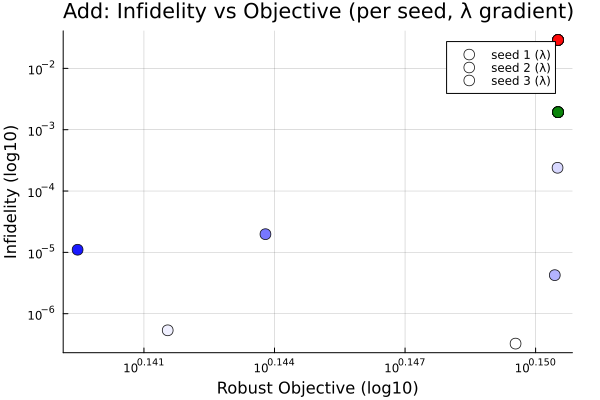

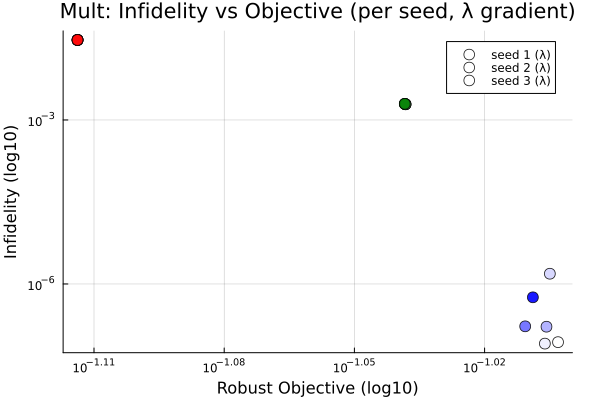

In [21]:
using ColorSchemes

to_infidelity(F::AbstractArray; floor_eps=1e-12) = max.(1 .- F, floor_eps)

titles      = ["Add", "Mult"]
fids_by_cfg = [additive_fidelities, multiplicative_fidelities]
obj_by_cfg  = [additive_obj,       multiplicative_obj]

# Good working palettes (Brewer are Capitalized; matplotlib are lowercase)
seed_gradients = [
    cgrad(:Oranges),  cgrad(:Greens),   cgrad(:Blues),
    cgrad(:magma),    cgrad(:plasma),   cgrad(:inferno),
    cgrad(:viridis),  cgrad(:cividis),
]

# Log-scale limits helper (positive-only, multiplicative padding)
function log_axis_minmax(x::AbstractVector; pad_frac::Float64 = 0.03)
    xpos = filter(>(0), x)
    if isempty(xpos)
        return (1e-8, 1.0)
    end
    xlo = minimum(xpos); xhi = maximum(xpos)
    pad = (xhi / xlo) ^ pad_frac
    (xlo / pad, xhi * pad)
end

for (cfg_idx, title_name) in enumerate(titles)
    Ftbl = fids_by_cfg[cfg_idx]      # (n_seeds, n_pts)
    objs = obj_by_cfg[cfg_idx]       # (n_seeds, n_pts)
    λ_all = vec(sweep_rob_loss_λ)    # length n_pts

    # --- global axis limits across ALL seeds/λ ---
    x_all_points = vec(objs)
    y_all_points = vec(to_infidelity(Ftbl))
    xlo, xhi = log_axis_minmax(x_all_points)
    ylo, yhi = log_axis_minmax(y_all_points)

    p = Plots.plot(
        xlabel = "Robust Objective (log10)",
        ylabel = "Infidelity (log10)",
        title  = "$title_name: Infidelity vs Objective (per seed, λ gradient)",
        xscale = :log10, yscale = :log10,
        xlims  = (xlo, xhi), ylims = (ylo, yhi),
        right_margin = 5mm, legend = :topright,
        colorbar = false, grid = true, gridalpha = 0.25
    )

    n_seeds = size(Ftbl, 1)
    base_colors = [:red, :green, :blue, :orange, :purple]

    for s in 1:n_seeds
        grad = cgrad([:white, base_colors[mod1(s,length(base_colors))]])
        x = vec(objs[s, :])
        y = to_infidelity(vec(Ftbl[s, :]))
        pos = (x .> 0) .& (y .> 0)

        Plots.scatter!(
            p, x[pos], y[pos];
            zcolor=λ_all[pos], color=grad,
            label="seed $s (λ)", alpha=0.9, markersize=6,
        )
    end

    # for s in 1:n_seeds
    #     # force 1D vectors (avoids 1×N shapes and @view quirks)
    #     x  = vec(objs[s, :])
    #     Fy = vec(Ftbl[s, :])
    #     y  = to_infidelity(Fy)

    #     # keep only positive & finite for log plotting
    #     pos = (x .> 0) .& (y .> 0) .& isfinite.(x) .& isfinite.(y)
    #     if !any(pos)
    #         @warn "Seed $s has no positive/finite points; skipping in log plot."
    #         continue
    #     end

    #     # per-seed λ range => full gradient usage (prevents 'bleached' look)
    #     lam  = λ_all[pos]
    #     cmin = minimum(lam); cmax = maximum(lam)
    #     grad = seed_gradients[mod1(s, length(seed_gradients))]

    #     Plots.scatter!(
    #         p, x[pos], y[pos];
    #         zcolor = lam, color = grad, clims = (cmin, cmax),
    #         label = "seed $s (λ)",
    #         markersize = 6, alpha = 1.0,
    #         markerstrokewidth = 0,  # avoid white rims/bleaching
    #     )
    # end

    display(p)
end


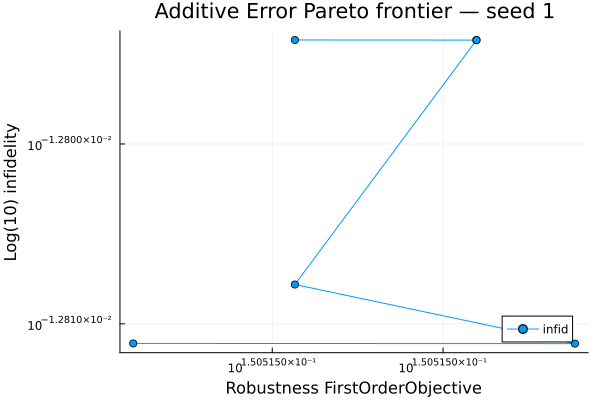

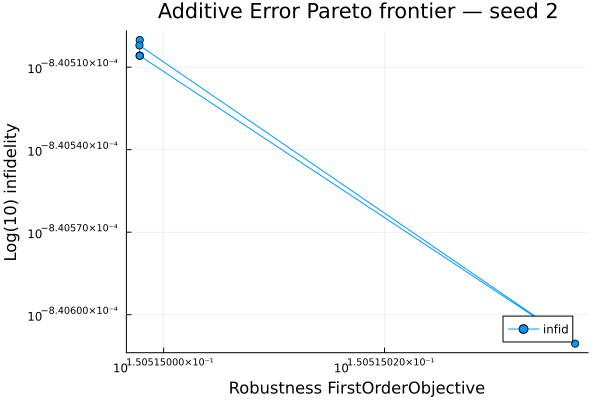

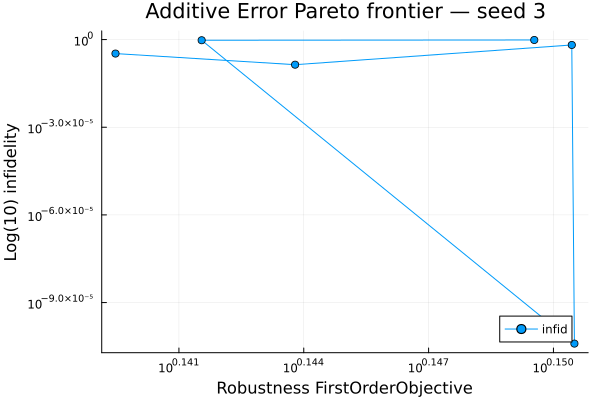

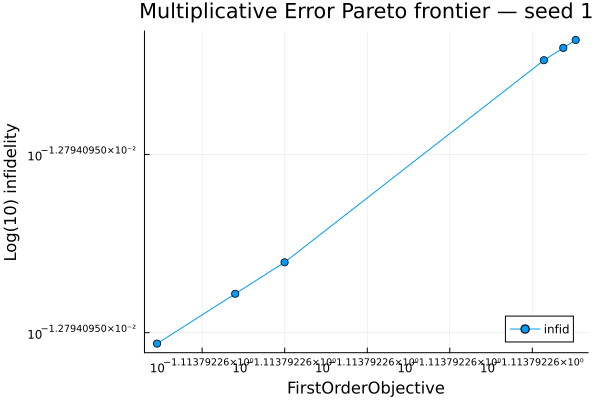

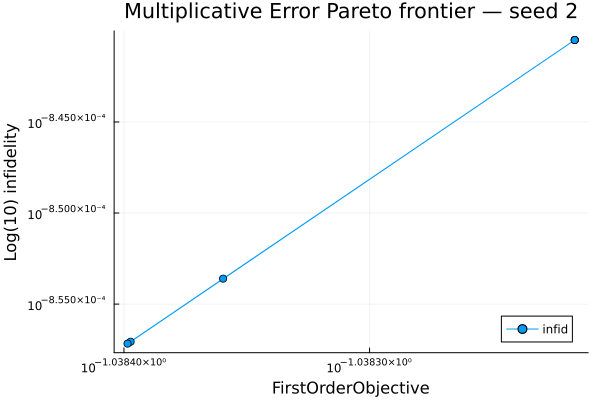

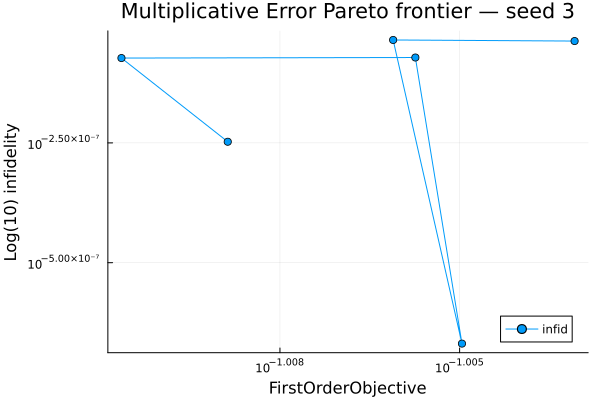

In [13]:
sweep_rob_loss_λ = exp.(range(log(.1), log(1), length=6))

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness FirstOrderObjective",
        ylabel="Log(10) infidelity",
        title="Additive Error Pareto frontier — seed $s",
        xscale = :log10, yscale = :log10,
        legend=:bottomright, grid=true
    )
    xs = Float64[]
    ys = Float64[]
    for (j, f) in enumerate(sweep_rob_loss_λ)
        obj = additive_obj[s,j]
        push!(xs, obj)
        push!(ys, additive_fidelities[s,j])
    end
    # sort by x for a nice line
    # ord = sortperm(xs)
    name = "infid"
    Plots.plot!(plt, xs, ys, marker=:circle, label=name)
    display(plt)
end

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="FirstOrderObjective",
        ylabel="Log(10) infidelity",
        title="Multiplicative Error Pareto frontier — seed $s",
        legend=:bottomright, grid=true,
        xscale = :log10, yscale = :log10
    )
    xs = Float64[]  # robustness
    ys = Float64[]  # fidelity
    for (j, f) in enumerate(sweep_rob_loss_λ)
        obj = multiplicative_obj[s,j]
        push!(xs, obj)
        push!(ys, multiplicative_fidelities[s,j])
    end
    # sort by x for a nice line
    # ord = sortperm(xs)
    name = "infid"
    Plots.plot!(plt, xs, ys, marker=:circle, label=String(name))
    display(plt)
end

In [14]:
using DataFrames

obj_vals = zeros(n_seeds, n_lambdas)
Hₑ_add = a -> PAULIS.X
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive

# fidelity storages per noise model
additive_fidelities       = zeros(n_seeds, n_lambdas)
multiplicative_fidelities = zeros(n_seeds, n_lambdas)

# Helper: safe infidelity for log plots
to_infidelity(F::AbstractVector; floor_eps=1e-12) = max.(1 .- F, floor_eps)

# Compute obj_vals and fidelities
configs = [
    (add_probs,  additive_fidelities,       Hₑ_add),
    (mult_probs, multiplicative_fidelities, Hₑ_mult)
]
titles = ["Add", "Mult"]

for (probs, fidelities, Hₑ) in configs
    println("----------------! New noise model !----------------")
    for seed_idx in 1:n_seeds
        for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
            prob = probs[seed_idx, λ_idx]
            println("\nProcessing λ = $λ")

            obj = QuantumObjectives.FirstOrderObjective(Hₑ, prob.trajectory; Q_t=λ)

            Z_vec = vec(prob.trajectory)
            obj_vals[seed_idx, λ_idx] = (λ > 0 ? obj.L(Z_vec)/λ : NaN)

            # Robust rollout fidelity (against nominal system unless you want otherwise)
            fidelities[seed_idx, λ_idx] = unitary_rollout_fidelity(prob.trajectory, sys)
        end
    end
end

results = DataFrame(Seed=Int[], λ=Float64[], NoiseModel=String[],
                    ObjectiveValue=Float64[], Fidelity=Float64[])

for (cfg_idx, title_name) in enumerate(titles)
    Ftbl = (cfg_idx == 1) ? additive_fidelities : multiplicative_fidelities
    for seed_idx in 1:n_seeds, (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        push!(results, (
            seed_idx,
            λ,
            title_name,
            obj_vals[seed_idx, λ_idx],
            Ftbl[seed_idx, λ_idx],
        ))
    end
end

# Save the table (optional)
CSV.write("fidelity_vs_objective.csv", results)

# Show first rows inline
first(results, 100) |> display

----------------! New noise model !----------------

Processing λ = 0.10000000000000002

Processing λ = 0.15848931924611137

Processing λ = 0.25118864315095807

Processing λ = 0.39810717055349726

Processing λ = 0.6309573444801932

Processing λ = 1.0

Processing λ = 0.10000000000000002

Processing λ = 0.15848931924611137

Processing λ = 0.25118864315095807

Processing λ = 0.39810717055349726

Processing λ = 0.6309573444801932

Processing λ = 1.0

Processing λ = 0.10000000000000002

Processing λ = 0.15848931924611137

Processing λ = 0.25118864315095807

Processing λ = 0.39810717055349726

Processing λ = 0.6309573444801932

Processing λ = 1.0
----------------! New noise model !----------------

Processing λ = 0.10000000000000002

Processing λ = 0.15848931924611137

Processing λ = 0.25118864315095807

Processing λ = 0.39810717055349726

Processing λ = 0.6309573444801932

Processing λ = 1.0

Processing λ = 0.10000000000000002

Processing λ = 0.15848931924611137

Processing λ = 0.2511886431

36×5 DataFrame
 Row │ Seed   λ         NoiseModel  ObjectiveValue  Fidelity 
     │ Int64  Float64   String      Float64         Float64  
─────┼───────────────────────────────────────────────────────
   1 │     1  0.1       Add              0.0769498  0.97097
   2 │     1  0.158489  Add              0.0769498  0.97097
   3 │     1  0.251189  Add              0.0769498  0.97097
   4 │     1  0.398107  Add              0.0769498  0.97094
   5 │     1  0.630957  Add              0.0769498  0.970932
   6 │     1  1.0       Add              0.0769498  0.970932
   7 │     2  0.1       Add              0.0915764  0.998067
   8 │     2  0.158489  Add              0.0915764  0.998067
  ⋮  │   ⋮       ⋮          ⋮             ⋮            ⋮
  30 │     2  1.0       Mult             0.091538   0.998028
  31 │     3  0.1       Mult             0.0992933  1.0
  32 │     3  0.158489  Mult             0.098603   1.0
  33 │     3  0.251189  Mult             0.0988642  0.999998
  34 │     3  0.398107  Mult             0.0986873  1.0
  35 │     3  0.630957  Mult             0.0975783  1.0
  36 │     3  1.0       Mult             0.0979779  0.999999
                                              21 rows omitted